In [1]:
from basicgeo import P2, P3
from wingshape import WingShape
from parapolygraph import ParamPolyGraph
import numpy, math

wingshape = WingShape("P7-211221-XYZ geometry.csv")        
parapolygraph = ParamPolyGraph(wingshape, "test7.json", splineweight=0.8, legsampleleng=0.05)


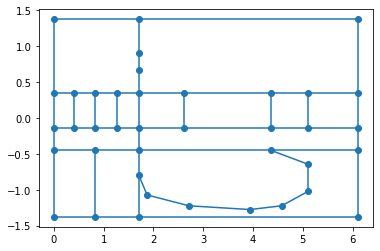

In [93]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

def legsdata(nodes, paths):
    return [[nodes[paths[i]], nodes[paths[i+1]]]  for i in range(0, len(paths), 2)]

plt.figure()
npts = numpy.array(list(parapolygraph.nodes.values()))
plt.gca().add_collection(LineCollection(legsdata(parapolygraph.nodes, parapolygraph.paths)))
plt.scatter(npts[:,0], npts[:,1])
plt.gca().autoscale()

In [69]:
urg, vrg = wingshape.urange, wingshape.vrange

def boxdistort(p, bp0, bp1, newbp0, newbp1):
    if p.u < min(bp0.u, bp1.u) or p.u > max(bp0.u, bp1.u):
        return p
    if p.v < min(bp0.v, bp1.v) or p.v > max(bp0.v, bp1.v):
        return p
    assert bp0 == newbp0 or bp1 == newbp1
    lamu = (p.u - bp0.u)/(bp1.u - bp0.u)
    lamv = (p.v - bp0.v)/(bp1.v - bp0.v)
    bpr = P2(bp1.u, bp0.v)
    bpl = P2(bp0.u, bp1.v)
    prvlo = newbp0*(1-lamu) + bpr*lamu
    prvhi = bpl*(1-lamu) + newbp1*lamu
    return prvlo*(1-lamv) + prvhi*lamv


def quadboxdistort(p, pmid, pnext, pradu, pradv, urg, vrg):
    assert abs(pmid.u - pnext.u) < pradu and abs(pmid.v - pnext.v) < pradv
    if abs(p.u - pmid.u) > pradu or abs(p.v - pmid.v) > pradv:
        return p
    pmum, pmup = max(urg[0], pmid.u-pradu), min(urg[1], pmid.u+pradu)
    pmvm, pmvp = max(vrg[0], pmid.v-pradv), min(vrg[1], pmid.v+pradv)
    if p.u < pmid.u:
        if p.v < pmid.v:
            return boxdistort(p, P2(pmum, pmvm), pmid, P2(pmum, pmvm), pnext)
        else:
            return boxdistort(p, P2(pmum, pmvp), pmid, P2(pmum, pmvp), pnext)
    else:
        if p.v < pmid.v:
            return boxdistort(p, P2(pmup, pmvm), pmid, P2(pmup, pmvm), pnext)
        else:
            return boxdistort(p, P2(pmup, pmvp), pmid, P2(pmup, pmvp), pnext)
            

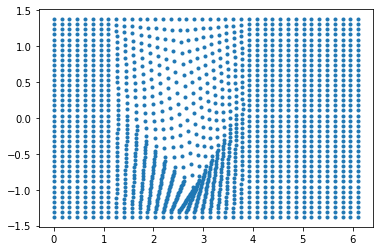

In [84]:
samplepoints = [P2(u, v)  for u in numpy.linspace(urg[0], urg[1], 40)  \
                          for v in numpy.linspace(vrg[0], vrg[1], 40)]
pts = numpy.array(samplepoints)

pmid, pnext = P2(2.5, 0.3), P2(2.8, -1)
pradu, pradv = 1.4, 1.6

tpts = numpy.array([quadboxdistort(p, pmid, pnext, pradu, pradv, urg, vrg)  for p in samplepoints])
plt.scatter(tpts[:,0], tpts[:,1], marker=".")
           

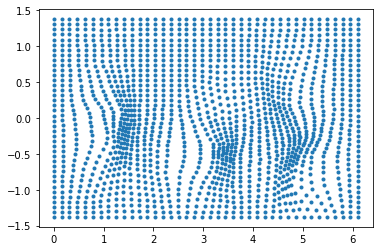

In [90]:
import random
tpts = samplepoints
murg = urg[0]*0.9 + urg[1]*0.1, urg[0]*0.1 + urg[1]*0.9
mvrg = vrg[0]*0.9 + vrg[1]*0.1, vrg[0]*0.1 + vrg[1]*0.9
for i in range(23):
    pmid = P2(random.uniform(murg[0], murg[1]), random.uniform(mvrg[0], mvrg[1]))
    pnext = P2(random.uniform(murg[0], murg[1]), random.uniform(mvrg[0], mvrg[1]))
    pnext = pmid*0.9 + pnext*0.1
    pradu = max(0.7, abs(pmid.u - pnext.u)*1.5)
    pradv = max(0.7, abs(pmid.v - pnext.v)*1.5)
    tpts = numpy.array([quadboxdistort(P2(*p), pmid, pnext, pradu, pradv, urg, vrg)  for p in tpts])
plt.scatter(tpts[:,0], tpts[:,1], marker=".")


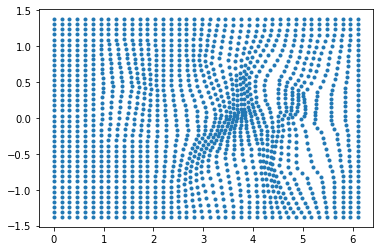

In [92]:
import random
tpts = samplepoints
murg = urg[0]*0.9 + urg[1]*0.1, urg[0]*0.1 + urg[1]*0.9
mvrg = vrg[0]*0.9 + vrg[1]*0.1, vrg[0]*0.1 + vrg[1]*0.9
genesequence = [ ]
for i in range(23):
    pmid = P2(random.uniform(murg[0], murg[1]), random.uniform(mvrg[0], mvrg[1]))
    pnext = P2(random.uniform(murg[0], murg[1]), random.uniform(mvrg[0], mvrg[1]))
    pnext = pmid*0.9 + pnext*0.1
    pradu = max(0.7, abs(pmid.u - pnext.u)*1.5)
    pradv = max(0.7, abs(pmid.v - pnext.v)*1.5)
    genesequence.extend([ pmid.u, pmid.v, pnext.u, pnext.v, pradu, pradv ])
    

for i in range(0, len(genesequence), 6):
    pmid, pnext, pradu, pradv = P2(genesequence[i], genesequence[i+1]), P2(genesequence[i+2], genesequence[i+3]), genesequence[4], genesequence[5]
    tpts = numpy.array([quadboxdistort(P2(*p), pmid, pnext, pradu, pradv, urg, vrg)  for p in tpts])

plt.scatter(tpts[:,0], tpts[:,1], marker=".")


In [97]:
def applygenseq(p, genesequence, urg, vrg):
    for i in range(0, len(genesequence), 6):
        pmid, pnext, pradu, pradv = P2(genesequence[i], genesequence[i+1]), P2(genesequence[i+2], genesequence[i+3]), genesequence[4], genesequence[5]
        if urg[0] < pmid.u < urg[1] and vrg[0] < pmid.v < vrg[1] and \
           urg[0] < pnext.u < urg[1] and vrg[0] < pnext.v < vrg[1] and \
           abs(pmid.u - pnext.u) < pradu and abs(pmid.v - pnext.v) < pradv:
            p = quadboxdistort(p, pmid, pnext, pradu, pradv, urg, vrg)
    return p


<Figure size 432x288 with 0 Axes>

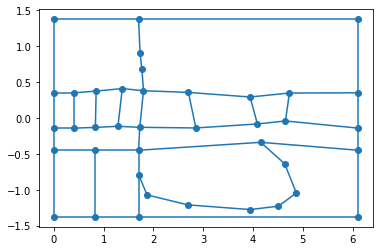

In [98]:
plt.figure()

distortednodes = dict((name, applygenseq(p, genesequence, urg, vrg))  for name, p in parapolygraph.nodes.items())
plt.figure()
npts = numpy.array(list(distortednodes.values()))
plt.gca().add_collection(LineCollection(legsdata(distortednodes, parapolygraph.paths)))
plt.scatter(npts[:,0], npts[:,1])
plt.gca().autoscale()

In [ ]:
# We can start with a genesequence of size 6*n within the ranges of urg and vrg for u and v values, 
# and positive values for the radiuses, then we can run PyGAD to generate distortions which we
# spline, then triangulate, then project, then flatten, then measure for distortion and score.

# This is the function, which takes [nodes] and [paths] and returns a score

# We need to hand this off to be computed over a large amount of time and generations, 
# and plot the fitness curve from it.  Make sure we trap any crashes in the code and score them 
# as zero (hopefully doesn't get stuck in infinite loops).  

# Code should run as a command line python script.  (No time to parallize it for the moment, but the tech
# is there.)

# This will always find a cut that is flatter since it is starting from your answer.
# The objective is to see (a) how much flatter, and (b) if there are any surprises


